# Creation and optimization of classification models

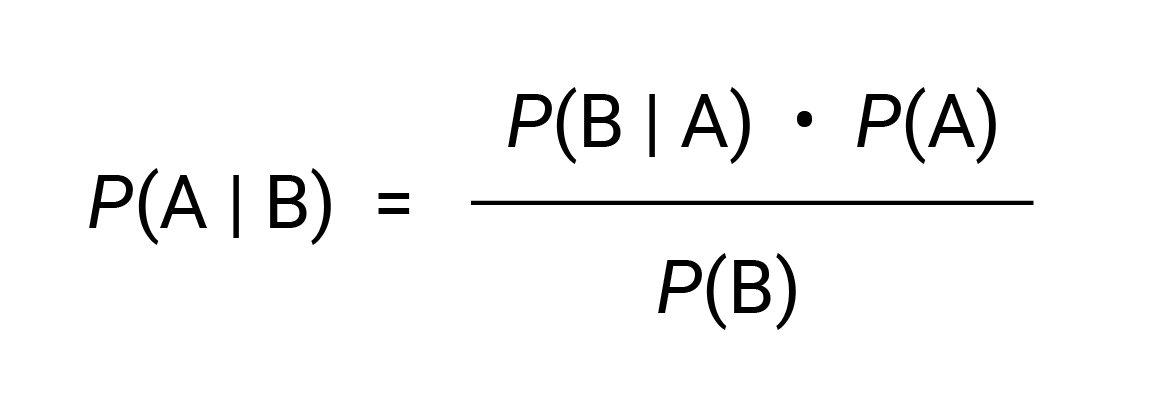

### Objetives
- With all the data that have been annotated, based on *Active Learning*, we will optimize the models to perform the final ensemble.
- The expected output is the models trained and optimized to improve the model previously used in production.
---

## 1 - Library imports

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

The cell below was used because the model was built with data hosted on the G drive and used by Google Collab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Here we will use the dataset formed from the active learning of the previous step

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projetos/Recomendação jogos/df_after_active_learning.csv", index_col=0)
df1 = df1[df1['y'].notnull()]
df1['novo'] = 0

In [ ]:
X_up = df1.copy().drop(columns=['y','novo'])
y_up = df1['y'].copy()
title= X_up['developer'].fillna(' ')
from sklearn.feature_extraction.text import TfidfVectorizer
X_up=X_up.copy().drop(columns=['release_data', 'tittle', 'genre', 'publisher', 'rating', 'developer'])


###Now that we are looking to improve the models more rigorously based on the chosen metrics, it is important to assess their generalizability. Therefore, we will use the so-called cross validation, represented by the image below.

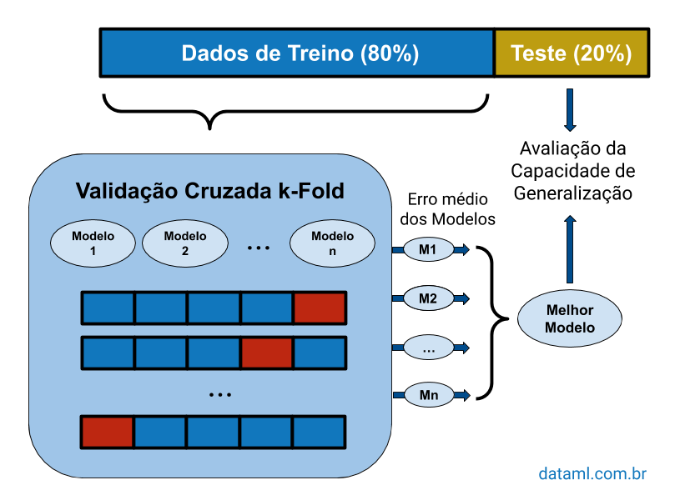

### Through this technique, the data are divided into blocks (Folds) and different training/validation combinations are created with these blocks, in order to reduce the chances of getting only one biased combination and, thus, allowing a greater capacity for generalization to our model

## 2 - Bayesian Hyperparameter Optimization

### There are different techniques to choose/optimize the hyperparameters of a *machine learning* model, among the most used are *Grid Search* and *Random Search* that act as follows:

* In *Grid Search* an array is created with several combinations of parameters, within a range with *steps* defined by the user. With this matrix, all possible configurations are tested, ensuring that we choose the best option available within that universe, but on the other hand, this requires a lot of processing and time, since we will carry out a massive amount of training;

* *Random Search* performs a random search within a user-defined range. Basically, we will "guess" some combinations and analyze their result, being able to find a very good solution or not, remembering that the user will choose how many times the algorithm will perform the "guesses";

### To ensure a good result and save time and processing, another solution was used: Bayesian optimization, which works as follows:

* First, a *Random Search* is performed to generate some models that will be used as a basis for optimization;
* Once this is done, the algorithm "learns" which path to follow and searches for the optimal result;
* Note: it is worth mentioning that nothing guarantees that we will reach the global optimum, but ideally the algorithm will converge (we will check this later)

## 2.1 - Random Forest

### Here a function was created to be used inside gp_minimize( ), which is the optimizer. Note that the function returns a negative value, this happens because we are working to minimize our objective, so it is necessary to invert the objective value so that it is maximized.
### Note: Both the classifier and TfidfVectorizer() hyperparameters were optimized
### At Random Forest, the goal was to optimize *Average Precision* and to evaluate the results, cross-validation was also used

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.sparse import hstack
!pip install scikit-optimize
from skopt import gp_minimize

count=0

def tune_rf(params):
    
    global count
    count=count+1

    max_features = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    min_samples_split = params[3]
    n_estimators = params[4]
    
    min_df = params[5]
    ngram_range = (1, params[6])
    
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    title_bow = title_vec.fit_transform(title)
    
    X_up_wtitle = hstack([X_up, title_bow])
    
    rf= RandomForestClassifier(
                               max_features=max_features,
                               max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               min_samples_split=min_samples_split,
                               n_estimators=n_estimators,
                               class_weight="balanced", 
                               n_jobs=-1, 
                               random_state=1)
    resultados_aps=[]
    resultados_roc=[]
    
    kf= RepeatedKFold(n_splits=2, n_repeats=1, random_state=5)
    for train,valid in kf.split(X_up_wtitle):

        Xtr, Xvld = X_up_wtitle.toarray()[train,:], X_up_wtitle.toarray()[valid,:]
        ytr, yvld = y_up.iloc[train], y_up.iloc[valid]

        rf.fit(Xtr,ytr)
        p=rf.predict_proba(Xvld)[:,1]

        aps=average_precision_score(yvld, p)
        resultados_aps.append(aps)
        
        roc=roc_auc_score(yvld, p)
        resultados_roc.append(roc)
    
    print('Iteração {n} / parametros:{params}'.format(n=count, 
                                                      params=params
                                                     ))
    print('APS = {aps} / AUC-ROC = {roc}'.format(aps=round(np.mean(resultados_aps),4),
                                                 roc=round(np.mean(resultados_roc),4)
                                                ))
    print('---')
          
    return -np.mean(resultados_aps)


space = [
         ('auto', 'sqrt'), # max_features
         (10, 70), # max_depth
         (1, 6), # min_samples_leaf
         (2, 10), # min_samples_split
         (500, 3000), # n_estimators
         (1, 20), # n_estimators
         (1, 5), # ngram_range
        ]
       

res_rf = gp_minimize(tune_rf,
                     space,
                     n_calls=99,
                     n_random_starts=40,
                     random_state=16,
#                      verbose=1
                 )

     |████████████████████████████████| 100 kB 5.1 MB/s 
Iteração 1 / parametros:['auto', 13, 3, 3, 2261, 4, 4]
APS = 0.8645 / AUC-ROC = 0.9636
---
Iteração 2 / parametros:['sqrt', 61, 4, 3, 1986, 12, 4]
APS = 0.8155 / AUC-ROC = 0.9572
---
Iteração 3 / parametros:['auto', 53, 3, 3, 1270, 14, 3]
APS = 0.821 / AUC-ROC = 0.9582
---
Iteração 4 / parametros:['auto', 26, 2, 9, 648, 5, 4]
APS = 0.865 / AUC-ROC = 0.9647
---
Iteração 5 / parametros:['sqrt', 40, 3, 5, 741, 14, 4]
APS = 0.8253 / AUC-ROC = 0.9583
---
Iteração 6 / parametros:['sqrt', 69, 5, 3, 1523, 6, 4]
APS = 0.8505 / AUC-ROC = 0.9594
---
Iteração 7 / parametros:['sqrt', 20, 5, 3, 1219, 16, 3]
APS = 0.818 / AUC-ROC = 0.9567
---
Iteração 8 / parametros:['auto', 56, 1, 7, 2167, 8, 3]
APS = 0.858 / AUC-ROC = 0.9653
---
Iteração 9 / parametros:['sqrt', 53, 6, 10, 2414, 14, 4]
APS = 0.8073 / AUC-ROC = 0.9551
---
Iteração 10 / parametros:['auto', 53, 2, 7, 2556, 16, 5]
APS = 0.8333 / AUC-ROC = 0.9605
---
Iteração 11 / parametros:['sqrt

### The .x argument returns the best hyperparameters that were found in the optimization phase

In [ ]:
res_rf.x

['auto', 22, 1, 2, 3000, 2, 1]

### Finally, we plotted our objective over the iterations to ensure it was converging to a coherent value

Text(0.5, 1.0, 'Convergence Plot - Random Forest')

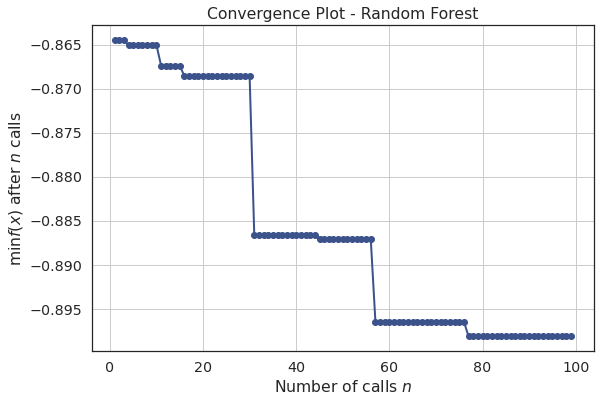

In [ ]:
%matplotlib inline
sns.set(style='white',font_scale=1.3, rc={'figure.figsize':(9,6)})

from skopt.plots import plot_convergence
plot_convergence(res_rf)
# plt.ylim([-0.4,0])
plt.title('Convergence Plot - Random Forest')

##     

## 2.2 - LightGBM


### The procedure done in RandomForest was repeated for LightGBM
### In this model, the objective was to optimize the AUC - ROC, in order to create a more robust *ensemble*

In [ ]:
from lightgbm import LGBMClassifier

count=0

def tune_lgbm(params):
    
    global count
    count=count+1

    lr = params[0]
    max_depth = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    
    min_df = params[6]
    ngram_range = (1, params[7])
    
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    title_bow = title_vec.fit_transform(title)
    
    X_up_wtitle = hstack([X_up, title_bow])
    
    lgbm = LGBMClassifier(learning_rate=lr,
                          num_leaves=2 ** max_depth,
                          max_depth=max_depth,
                          min_child_samples=min_child_samples,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          bagging_freq=1,
                          n_estimators=n_estimators,
                          random_state=0, 
                          class_weight="balanced", 
                          n_jobs=-1)
    resultados_aps=[]
    resultados_roc=[]
    
    kf= RepeatedKFold(n_splits=2, n_repeats=1, random_state=5)
    for train,valid in kf.split(X_up_wtitle):

        Xtr, Xvld = X_up_wtitle.toarray()[train,:], X_up_wtitle.toarray()[valid,:]
        ytr, yvld = y_up.iloc[train], y_up.iloc[valid]

        lgbm.fit(Xtr,ytr)
        p=lgbm.predict_proba(Xvld)[:,1]

        aps=average_precision_score(yvld, p)
        resultados_aps.append(aps)
        
        roc=roc_auc_score(yvld, p)
        resultados_roc.append(roc)
        
    print('Iteração {n} / parametros:{params}'.format(n=count, 
                                                      params=params
                                                     ))
    print('APS = {aps} / AUC-ROC = {roc}'.format(aps=round(np.mean(resultados_aps),4),
                                                 roc=round(np.mean(resultados_roc),4)
                                                ))
    print('---')

    return -np.mean(resultados_aps)
          
space = [(1e-3, 1e-1, 'log-uniform'), # lr
          (1, 10), # max_depth
          (1, 20), # min_child_samples
          (0.05, 1.), # subsample
          (0.05, 1.), # colsample_bytree
          (100,1000), # n_estimators
          (1,5), # min_df
          (1,5)] # ngram_range
       

res_lgbm = gp_minimize(tune_lgbm, 
                       space,
                       n_calls=99, 
                       n_random_starts=40,
                       random_state=16,
                       #verbose=1
                 )

Iteração 1 / parametros:[0.004501034257432059, 2, 7, 0.18223484451094563, 0.7192409322554387, 239, 4, 4]
APS = 0.8525 / AUC-ROC = 0.9628
---
Iteração 2 / parametros:[0.048873535334964184, 7, 4, 0.6146125334241129, 0.5857379931995986, 754, 2, 4]
APS = 0.8408 / AUC-ROC = 0.9572
---
Iteração 3 / parametros:[0.005285302738556758, 2, 7, 0.7217109945776673, 0.4252835383400519, 275, 2, 2]
APS = 0.8353 / AUC-ROC = 0.9587
---
Iteração 4 / parametros:[0.043899935124562806, 2, 5, 0.7730836106749692, 0.8886409141192313, 552, 3, 3]
APS = 0.8347 / AUC-ROC = 0.961
---
Iteração 5 / parametros:[0.0015593236533173003, 7, 17, 0.6333869656771897, 0.986077066924187, 760, 1, 3]
APS = 0.8424 / AUC-ROC = 0.962
---
Iteração 6 / parametros:[0.0030901995236619615, 8, 16, 0.20174276846379458, 0.7927350384787077, 221, 2, 4]
APS = 0.8772 / AUC-ROC = 0.9665
---
Iteração 7 / parametros:[0.014192887617413044, 1, 15, 0.08047844831608797, 0.655672774232068, 700, 3, 3]
APS = 0.3042 / AUC-ROC = 0.5
---
Iteração 8 / parame

In [ ]:
res_lgbm.x

[0.0014297605607284994, 10, 1, 1.0, 0.44167203566850377, 1000, 4, 1]

### Here we can verify that the optimization converged, as in the previous model

Text(0.5, 1.0, 'Convergence Plot - LightGBM')

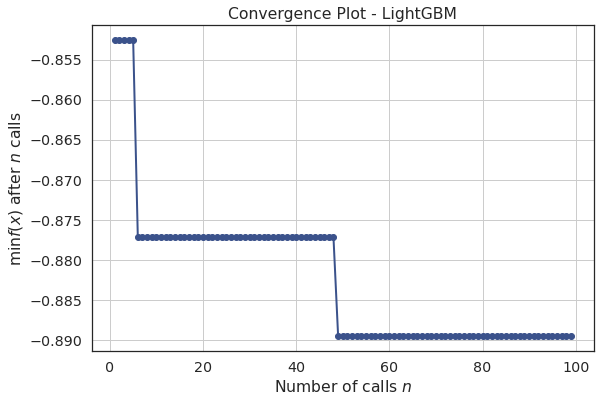

In [ ]:
%matplotlib inline
sns.set(style='white',font_scale=1.3, rc={'figure.figsize':(9,6)})

from skopt.plots import plot_convergence
plot_convergence(res_lgbm)
# plt.ylim([-0.4,0])
plt.title('Convergence Plot - LightGBM')

##       

## 3 - Ensemble


### In this topic, an *ensemble* technique was used, whose main objective is to combine several *machine learning* models and increase their performance and/or generalization capacity. For this, a weighted average of the "probability" results of each of the models used is made, remembering that the weights used in the weighted average are defined by the user and can be tested manually or automatically, depending on the complexity and amount of models in the *ensemble*.

### Found the optimal values ​​for both models, they were trained with all the data:

In [ ]:
def tune_ensemble(params_rf,params_lgbm,rf_weight,lgbm_weight):

    max_features = params_rf[0]
    max_depth = params_rf[1]
    min_samples_leaf = params_rf[2]
    min_samples_split = params_rf[3]
    n_estimators = params_rf[4]
    
    min_df = params_rf[5]
    ngram_range = (1, params_rf[6])
    
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    title_bow = title_vec.fit_transform(title)
    
    X_up_wtitle_rf = hstack([X_up, title_bow])
    
    rf= RandomForestClassifier(
                               max_features=max_features,
                               max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               min_samples_split=min_samples_split,
                               n_estimators=n_estimators,
                               class_weight="balanced", 
                               n_jobs=-1, 
                               random_state=1)
    
    lr = params_lgbm[0]
    max_depth = params_lgbm[1]
    min_child_samples = params_lgbm[2]
    subsample = params_lgbm[3]
    colsample_bytree = params_lgbm[4]
    n_estimators = params_lgbm[5]
    
    min_df = params_lgbm[6]
    ngram_range = (1, params_lgbm[7])
    
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    title_bow = title_vec.fit_transform(title)
    
    X_up_wtitle_lgbm = hstack([X_up, title_bow])
    
    lgbm = LGBMClassifier(learning_rate=lr,
                          num_leaves=2 ** max_depth,
                          max_depth=max_depth,
                          min_child_samples=min_child_samples,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          bagging_freq=1,
                          n_estimators=n_estimators,
                          random_state=0, 
                          class_weight="balanced", 
                          n_jobs=-1)
       
    resultados_aps=[]
    resultados_roc=[]
    
    kf= RepeatedKFold(n_splits=2, n_repeats=1, random_state=5)
    for train,valid in kf.split(X_up_wtitle_rf):

        Xtr_rf, Xvld_rf = X_up_wtitle_rf.toarray()[train,:], X_up_wtitle_rf.toarray()[valid,:]
        Xtr_lgbm, Xvld_lgbm = X_up_wtitle_lgbm.toarray()[train,:], X_up_wtitle_lgbm.toarray()[valid,:]
        
        ytr_rf, yvld_rf = y_up.iloc[train], y_up.iloc[valid]  
        ytr_lgbm, yvld_lgbm = y_up.iloc[train], y_up.iloc[valid]

        rf.fit(Xtr_rf,ytr_rf)
        lgbm.fit(Xtr_lgbm,ytr_lgbm)
        
        p=rf.predict_proba(Xvld_rf)[:,1]
        p2=lgbm.predict_proba(Xvld_lgbm)[:,1]
        p_ensemble= rf_weight*p + lgbm_weight*p2
        
        aps=average_precision_score(yvld_lgbm, p_ensemble)
        resultados_aps.append(aps)
        
        roc=roc_auc_score(yvld_lgbm, p_ensemble)
        resultados_roc.append(roc)
        
    print('Peso RF: {}'.format(rf_weight),'Peso lGBM: {}'.format(lgbm_weight))
    print('APS: {}'.format(round(np.mean(resultados_aps),4)),'AUC: {}'.format(round(np.mean(resultados_roc),4)))
    print('')
                                                                                 

In [ ]:
params_lgbm=res_lgbm.x
params_rf=res_rf.x

### Finally, all weight combinations within a defined range were tested:

In [ ]:
from itertools import combinations 
  
def findPairs(lst, K): 
    return [pair for pair in combinations(lst, 2) if sum(pair) == K] 

In [ ]:
numbers = np.arange(0.05, 1.05, 0.05).tolist()
pares=findPairs(numbers,1)
for x,y in pares:
    tune_ensemble(params_rf,params_lgbm,round(x,2),round(y,2))
    tune_ensemble(params_rf,params_lgbm,round(y,2),round(x,2))

Peso RF: 0.05 Peso lGBM: 0.95
APS: 0.8891 AUC: 0.9678

Peso RF: 0.95 Peso lGBM: 0.05
APS: 0.8977 AUC: 0.9695

Peso RF: 0.15 Peso lGBM: 0.85
APS: 0.8915 AUC: 0.9682

Peso RF: 0.85 Peso lGBM: 0.15
APS: 0.8973 AUC: 0.9695

Peso RF: 0.2 Peso lGBM: 0.8
APS: 0.8927 AUC: 0.9683

Peso RF: 0.8 Peso lGBM: 0.2
APS: 0.899 AUC: 0.9697

Peso RF: 0.25 Peso lGBM: 0.75
APS: 0.8946 AUC: 0.9686

Peso RF: 0.75 Peso lGBM: 0.25
APS: 0.899 AUC: 0.9698

Peso RF: 0.3 Peso lGBM: 0.7
APS: 0.8951 AUC: 0.9688

Peso RF: 0.7 Peso lGBM: 0.3
APS: 0.8985 AUC: 0.9699

Peso RF: 0.4 Peso lGBM: 0.6
APS: 0.8965 AUC: 0.9693

Peso RF: 0.6 Peso lGBM: 0.4
APS: 0.8984 AUC: 0.9696

Peso RF: 0.45 Peso lGBM: 0.55
APS: 0.8971 AUC: 0.9693

Peso RF: 0.55 Peso lGBM: 0.45
APS: 0.8983 AUC: 0.9695



### As the *ensemble* obtained results without much variation, I chose to use 50% of each model, since each one optimizes a metric, in order to increase its generalization capacity when in production.

## 4 - Saving models

### To use the models in the deploy, they were trained with all the annotated data:

In [ ]:
params=params_lgbm

lr = params[0]
max_depth = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]
n_estimators = params[5]

min_df = params[6]
ngram_range = (1, params[7])


title_vec_lgbm = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
title_bow = title_vec_lgbm.fit_transform(title)

X_up_wtitle = hstack([X_up, title_bow])

lgbm = LGBMClassifier(learning_rate=lr,
                      num_leaves=2 ** max_depth,
                      max_depth=max_depth,
                      min_child_samples=min_child_samples,
                      subsample=subsample,
                      colsample_bytree=colsample_bytree,
                      bagging_freq=1,
                      n_estimators=n_estimators,
                      random_state=0, 
                      class_weight="balanced", 
                      n_jobs=-1)

lgbm.fit(X_up_wtitle,y_up)

LGBMClassifier(bagging_freq=1, class_weight='balanced',
               colsample_bytree=0.44167203566850377,
               learning_rate=0.0014297605607284994, max_depth=10,
               min_child_samples=1, n_estimators=1000, num_leaves=1024,
               random_state=0)

In [ ]:
params=params_rf

max_features = params[0]
max_depth = params[1]
min_samples_leaf = params[2]
min_samples_split = params[3]
n_estimators = params[4]

min_df = params[5]
ngram_range = (1, params[6])

title_vec_rf = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
title_bow = title_vec_rf.fit_transform(title)

X_up_wtitle = hstack([X_up, title_bow])

rf= RandomForestClassifier(
                           max_features=max_features,
                           max_depth=max_depth,
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split,
                           n_estimators=n_estimators,
                           class_weight="balanced", 
                           n_jobs=-1)

rf.fit(X_up_wtitle,y_up)

RandomForestClassifier(class_weight='balanced', max_depth=22, n_estimators=3000,
                       n_jobs=-1)

##       

##       